In [371]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [342]:
from skimage import color
from skimage import io

In [343]:
img1=mpimg.imread('class1.jpg')
img2=mpimg.imread('class2.jpg')
img3=mpimg.imread('class3.jpg')

In [344]:
img1_gr=color.rgb2gray(img1)
img2_gr=color.rgb2gray(img2)
img3_gr=color.rgb2gray(img3)

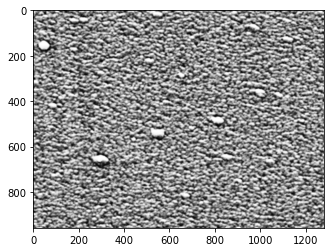

In [345]:
class_names=["Class 1","Class 2","Class 3"]
plt.imshow(img1_gr, cmap="gray")
plt.grid(False)

In [346]:
sx=8
sy=8

In [347]:
MAX_X = img1_gr.shape[0]
MAX_Y = img1_gr.shape[1]

In [348]:
class1_data=[]
class2_data=[]
class3_data=[]

for x_coord in np.arange(0,MAX_X-sx,sx):
    for y_coord in np.arange(0,MAX_Y-sy,sy):
        class1_data.append(img1_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class2_data.append(img2_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class3_data.append(img3_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])

Class 1


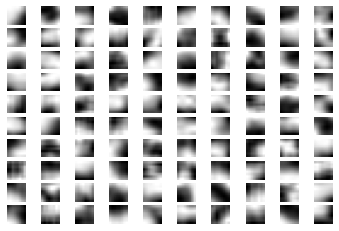

In [349]:
print("Class 1")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class1_data[np.random.randint(0,len(class1_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 2


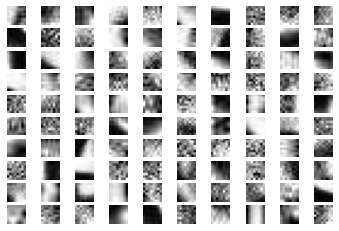

In [350]:
print("Class 2")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class2_data[np.random.randint(0,len(class2_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 3


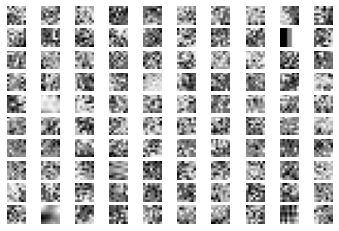

In [351]:
print("Class 3")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class3_data[np.random.randint(0,len(class3_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

In [352]:
X = np.vstack([class1_data, class2_data, class3_data])

In [353]:
labels = np.array([0]*len(class1_data) + [1]*len(class2_data) + [2]*len(class3_data))

In [354]:
color_dict={0:"red",1:"lightgreen",2:"blue"}

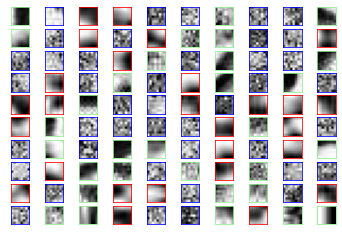

In [355]:
import os

output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

for i in range(100):
    plt.subplot(10,10,i+1)
    ind=np.random.randint(0,len(X))
    plt.imshow(X[ind], cmap="gray")
    ax = plt.gca()
    c=color_dict[labels[ind]]
    plt.setp(ax.spines.values(), color=c)
    #plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.grid(False)

plt.savefig(f'{output_dir}/grid_of_images.png')  # Save the entire grid of images
    
plt.show()

In [356]:


from sklearn.preprocessing import OneHotEncoder

In [357]:
y = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))

In [358]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K

In [359]:
def prob_to_class(y):
     return np.argmax(y,axis=1).reshape(-1,1)
    
def probabilities_to_class_converter(func):
    def f(y_true,y_pred,*args,**kwargs):
        return func(prob_to_class(y_true), prob_to_class(y_pred),*args,**kwargs)
    return f
def max_probability_confusion_matrix(y_true, y_pred):
    return confusion_matrix(
        prob_to_class(y_true),
        prob_to_class(y_pred)
    )
accuracy_score=probabilities_to_class_converter(accuracy_score)
precision_score=probabilities_to_class_converter(precision_score)
recall_score=probabilities_to_class_converter(recall_score)
f1_score = probabilities_to_class_converter(f1_score)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def plot_confusion_matrix(conf_matrix,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = conf_matrix
    # Only use the labels that appear in the data
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax


def plot_train_history(history):
    metrics=["accuracy","precision","recall","f1"]

    plt.figure(figsize=(7,7))

    for i,metric in enumerate(metrics):
        plt.subplot(2,2,i+1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history['val_'+metric], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    
    
def model_predict(model):
    return model.predict(X_test_ch)


def model_test_summary(model):
    y_pred = model_predict(model)
    cm=max_probability_confusion_matrix(y_test,y_pred)
    cm_df=pd.DataFrame(cm, columns=class_names, index=class_names)
    plot_confusion_matrix(cm,normalize=True)
    print("Precision: {}\nAccuracy: {}\nRecall: {}\nF1-score: {}".format(
        precision_score(y_test, y_pred, average="macro"),
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro")
    ))
    
    
def model_wrong_predictions(model):
    y_pred = model_predict(model)
    
    y_pred_class=prob_to_class(y_pred)    
    y_t=np.array(y_test_class.reshape(-1))[0]
    y_p=np.array(y_pred_class.reshape(-1))

    pred_df=pd.DataFrame({"True":y_t, "Pred":y_p})

    pred_df["Error"]=pred_df["True"]!=pred_df["Pred"]

    err_df=pred_df[pred_df["Error"]]

    for cl in range(3):
        print("True class: ",cl+1)
        subdf=err_df[err_df["True"]==cl]


        other_cl=list(range(3))
        other_cl.remove(cl)

        for pred_cl in other_cl:
            wrong_pred=subdf[subdf["Pred"]==pred_cl].index
            if len(wrong_pred)>0:
                wrong_predicted_indices=np.random.choice(subdf[subdf["Pred"]==pred_cl].index,size=4)

                print("Wrongly predicted as Class "+str(pred_cl+1))
                for ax_i,ind in enumerate(wrong_predicted_indices):
                    plt.subplot(2,2,ax_i+1)
                    plt.imshow(X_test[ind],cmap="gray")
                    plt.axis("off")
                    plt.grid(False)
                plt.show()
                
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42, shuffle=True)

In [360]:
y_test_class=prob_to_class(y_test)

In [361]:
X_train_ch=X_train.reshape(-1,sx,sy,1)
X_test_ch=X_test.reshape(-1,sx,sy,1)

In [362]:
input_shape = (sx,sy,1)
X_test_ch.shape

(8515, 8, 8, 1)

In [363]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer,Flatten,BatchNormalization,AveragePooling2D

input_shape=(sx,sy,1)

In [364]:
model=Sequential()#94.80

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(36, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(8,8,1)))




model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(150,input_shape=input_shape, activation="relu"))

model.add(Dense(100,input_shape=input_shape, activation="relu"))#94

model.add(Dense(50, activation="relu"))#94
model.add(Dense(20, activation="tanh"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure
model.add(Dense(10, activation="relu"))#92 per

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 7, 7, 64)          320       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 6, 6, 36)          9252      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 5, 5, 8)           1160      
_________________________________________________________________
flatten_16 (Flatten)         (None, 200)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_97 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_98 (Dense)             (None, 50)              

2023-10-15 14:11:15.598880: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


In [30]:
history=model.fit(X_train_ch,y_train, validation_data=(X_test_ch,y_test), batch_size=400, epochs=65, callbacks =[tensorboard_callback])

Epoch 1/65
  1/121 [..............................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9600 - precision: 0.9623 - recall: 0.9575 - f1: 0.9599

2023-10-15 16:16:38.670512: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2023-10-15 16:16:38.850284: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/train/plugins/profile/2023_10_15_16_16_38
2023-10-15 16:16:38.852372: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_10_15_16_16_38/jupyter.trace.json.gz
2023-10-15 16:16:38.852931: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.022 ms

2023-10-15 16:16:38.857354: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: logs/train/plugins/profile/2023_10_15_16_16_38Dumped tool data for overview_page.pb to logs/train/plugins/profile/2023_10_15_16_16_38/jupyter.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2023_10_15_16_16_38/jupyter.input_pipeline.pb
Dumped tool data for tensorfl

121/121 [==============================] - 24s 201ms/step - loss: 0.1181 - accuracy: 0.9553 - precision: 0.9554 - recall: 0.9549 - f1: 0.9552 - val_loss: 0.1350 - val_accuracy: 0.9507 - val_precision: 0.9502 - val_recall: 0.9497 - val_f1: 0.9499
Epoch 2/65
121/121 [==============================] - 23s 188ms/step - loss: 0.1142 - accuracy: 0.9571 - precision: 0.9574 - recall: 0.9569 - f1: 0.9571 - val_loss: 0.1412 - val_accuracy: 0.9480 - val_precision: 0.9480 - val_recall: 0.9479 - val_f1: 0.9479
Epoch 3/65
121/121 [==============================] - 23s 192ms/step - loss: 0.1105 - accuracy: 0.9574 - precision: 0.9575 - recall: 0.9572 - f1: 0.9574 - val_loss: 0.1564 - val_accuracy: 0.9417 - val_precision: 0.9432 - val_recall: 0.9414 - val_f1: 0.9423
Epoch 4/65
121/121 [==============================] - 23s 187ms/step - loss: 0.1093 - accuracy: 0.9594 - precision: 0.9596 - recall: 0.9591 - f1: 0.9593 - val_loss: 0.1471 - val_accuracy: 0.9470 - val_precision: 0.9466 - val_recall: 0.9464 

Epoch 33/65
121/121 [==============================] - 30s 248ms/step - loss: 0.0796 - accuracy: 0.9712 - precision: 0.9713 - recall: 0.9709 - f1: 0.9711 - val_loss: 0.1457 - val_accuracy: 0.9503 - val_precision: 0.9504 - val_recall: 0.9502 - val_f1: 0.9503
Epoch 34/65
121/121 [==============================] - 29s 240ms/step - loss: 0.0944 - accuracy: 0.9639 - precision: 0.9641 - recall: 0.9639 - f1: 0.9640 - val_loss: 0.1491 - val_accuracy: 0.9486 - val_precision: 0.9485 - val_recall: 0.9481 - val_f1: 0.9483
Epoch 35/65
121/121 [==============================] - 27s 219ms/step - loss: 0.0835 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9690 - f1: 0.9691 - val_loss: 0.1599 - val_accuracy: 0.9480 - val_precision: 0.9482 - val_recall: 0.9479 - val_f1: 0.9480
Epoch 36/65
121/121 [==============================] - 28s 230ms/step - loss: 0.0833 - accuracy: 0.9692 - precision: 0.9696 - recall: 0.9691 - f1: 0.9694 - val_loss: 0.1607 - val_accuracy: 0.9530 - val_precision: 0.9530 - val_

Epoch 65/65
121/121 [==============================] - 37s 305ms/step - loss: 0.0657 - accuracy: 0.9759 - precision: 0.9762 - recall: 0.9756 - f1: 0.9759 - val_loss: 0.2086 - val_accuracy: 0.9405 - val_precision: 0.9406 - val_recall: 0.9401 - val_f1: 0.9403


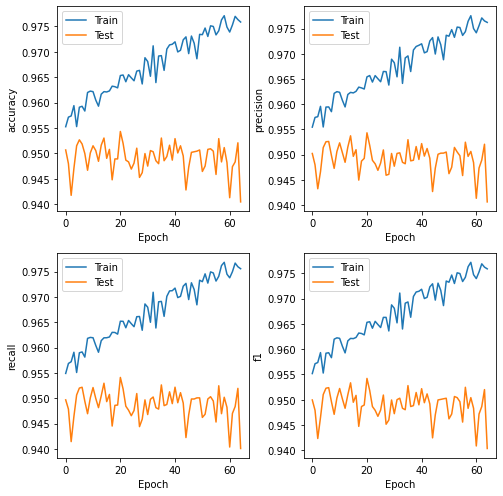

In [31]:
plot_train_history(history)
plt.savefig(f'{output_dir}/plot_train_history_8x8.png')  # Save the entire grid of images


Normalized confusion matrix
Precision: 0.9420470597856768
Accuracy: 0.9404580152671755
Recall: 0.9404572082912727
F1-score: 0.9407524306144119


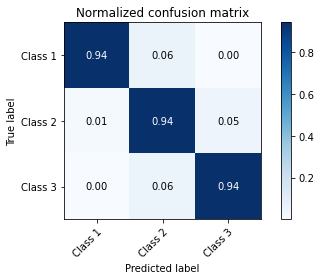

In [32]:
model_test_summary(model)

plt.savefig(f'{output_dir}/plot_confusion_matrix_8x8.png')  # Save the entire grid of images


True class:  1
True class:  2
Wrongly predicted as Class 1


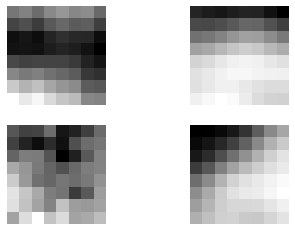

Wrongly predicted as Class 3


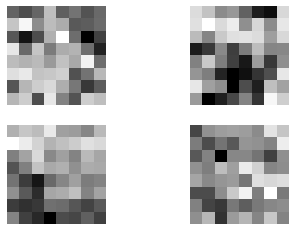

True class:  3


In [67]:
model_wrong_predictions(model)

In [68]:
from keras.layers import Convolution2D, Conv2D, Dropout, BatchNormalization, MaxPooling2D

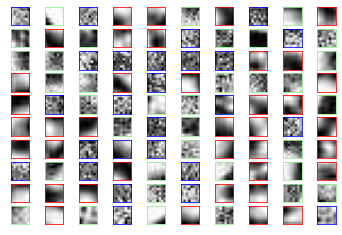

In [69]:
for i in range(100):
    plt.subplot(10,10,i+1)
    ind=np.random.randint(0,len(X))
    plt.imshow(X[ind], cmap="gray")
    ax = plt.gca()
    c=color_dict[labels[ind]]
    plt.setp(ax.spines.values(), color=c)
    #plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.grid(False)
plt.show()

## Try for prediction 


In [168]:
array = X_test_ch[20:21]

In [169]:
y_pred = model.predict(array)


In [170]:
y_tes = y_test[20]

max_index = int(np.argmax(y_tes, axis=0))

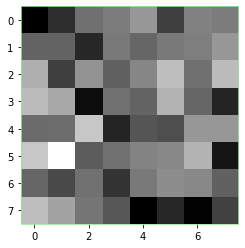

In [171]:
plt.imshow(array[0], cmap="gray")
ax = plt.gca()
c=color_dict[max_index]
plt.setp(ax.spines.values(), color=c)
plt.show()

In [172]:
max_index = int(np.argmax(y_pred, axis=1))

[None, None, None, None]

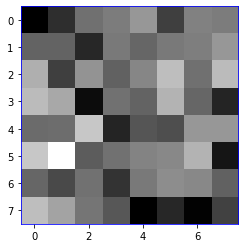

In [173]:
plt.imshow(array[0], cmap="gray")
ax = plt.gca()

c=color_dict[max_index]
plt.setp(ax.spines.values(), color=c)

# Nural network add some layer 

In [ ]:
model=Sequential()#94.1

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(8,8,1)))
model.add(AveragePooling2D())

model.add(Conv2D (32,(3,3), 1, activation='relu')) 
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(16,(3,3), 1, activation='relu')) 


model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(50,input_shape=input_shape, activation="relu"))

model.add(Dense(30,input_shape=input_shape, activation="relu"))#94

model.add(Dense(20, activation="relu"))#94
model.add(Dense(20, activation="relu"))
#model.add(Dense(6, activation="sigmoid"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

In [ ]:
#F1-score: 0.9370643262946102
model=Sequential()

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(8,8,1)))
model.add(MaxPooling2D(pool_size=(1, 1)))


model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(50,input_shape=input_shape, activation="relu"))

model.add(Dense(30,input_shape=input_shape, activation="relu"))#94

model.add(Dense(20, activation="relu"))#94
model.add(Dense(20, activation="relu"))
#model.add(Dense(6, activation="sigmoid"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

In [ ]:
model=Sequential()#94

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))
model.add(MaxPooling2D(pool_size=(1, 1)))


model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(50,input_shape=input_shape, activation="relu"))

model.add(Dense(30,input_shape=input_shape, activation="relu"))#94

model.add(Dense(20, activation="relu"))#94
model.add(Dense(20, activation="relu"))
#model.add(Dense(6, activation="sigmoid"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

In [ ]:
model=Sequential()#F1-score: 0.9549830800915234


#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(36, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(8,8,1)))



model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(50,input_shape=input_shape, activation="relu"))

model.add(Dense(30,input_shape=input_shape, activation="relu"))#94

model.add(Dense(20, activation="relu"))#94
model.add(Dense(20, activation="tanh"))
#model.add(Dense(6, activation="sigmoid"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

In [ ]:
model=Sequential()#94.80

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))
model.add(MaxPooling2D(pool_size=(1, 1)))




model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(64,input_shape=input_shape, activation="relu"))

model.add(Dense(50,input_shape=input_shape, activation="relu"))#94

model.add(Dense(40, activation="relu"))#94
model.add(Dense(20, activation="tanh"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure
model.add(Dense(20, activation="relu"))#92 per

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

In [ ]:
model=Sequential()#94.88

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(126, (2,2), 1, activation='relu', input_shape=(8,8,1)))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))

model.add(Conv2D(32, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(100,input_shape=input_shape, activation="relu"))
model.add(Dense(40, activation="tanh"))
model.add(Dense(50,input_shape=input_shape, activation="relu"))


model.add(Dense(40, activation="relu"))#94
#model.add(Dense(6, activation="relu")) # 93 prsentage acure

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

## 12x12

In [232]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [233]:
from skimage import color
from skimage import io

In [234]:
img1=mpimg.imread('class1.jpg')
img2=mpimg.imread('class2.jpg')
img3=mpimg.imread('class3.jpg')

In [235]:
img1_gr=color.rgb2gray(img1)
img2_gr=color.rgb2gray(img2)
img3_gr=color.rgb2gray(img3)

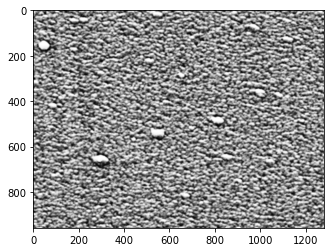

In [236]:
class_names=["Class 1","Class 2","Class 3"]
plt.imshow(img1_gr, cmap="gray")
plt.grid(False)

In [237]:
sx=12
sy=12

In [238]:
MAX_X = img1_gr.shape[0]
MAX_Y = img1_gr.shape[1]

In [239]:
class1_data=[]
class2_data=[]
class3_data=[]

for x_coord in np.arange(0,MAX_X-sx,sx):
    for y_coord in np.arange(0,MAX_Y-sy,sy):
        class1_data.append(img1_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class2_data.append(img2_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class3_data.append(img3_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])

Class 1


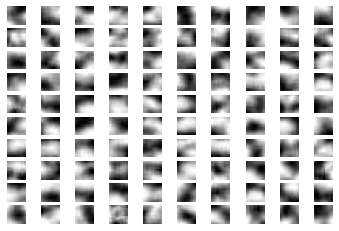

In [240]:
print("Class 1")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class1_data[np.random.randint(0,len(class1_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 2


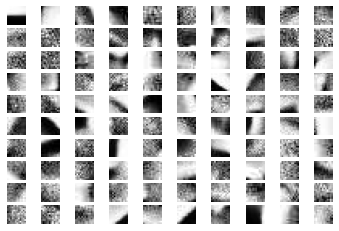

In [241]:
print("Class 2")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class2_data[np.random.randint(0,len(class2_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 3


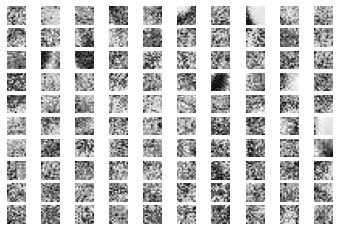

In [242]:
print("Class 3")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class3_data[np.random.randint(0,len(class3_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

In [243]:
X = np.vstack([class1_data, class2_data, class3_data])

In [244]:
labels = np.array([0]*len(class1_data) + [1]*len(class2_data) + [2]*len(class3_data))

In [245]:
color_dict={0:"red",1:"lightgreen",2:"blue"}

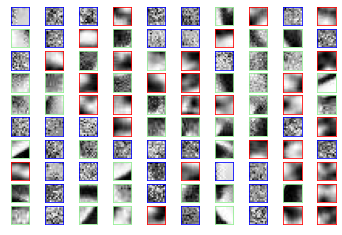

In [246]:
for i in range(100):
    plt.subplot(10,10,i+1)
    ind=np.random.randint(0,len(X))
    plt.imshow(X[ind], cmap="gray")
    ax = plt.gca()
    c=color_dict[labels[ind]]
    plt.setp(ax.spines.values(), color=c)
    #plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.grid(False)
plt.show()

In [247]:
from sklearn.preprocessing import OneHotEncoder

In [248]:
y = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))

In [249]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K

In [250]:
def prob_to_class(y):
     return np.argmax(y,axis=1).reshape(-1,1)
    
def probabilities_to_class_converter(func):
    def f(y_true,y_pred,*args,**kwargs):
        return func(prob_to_class(y_true), prob_to_class(y_pred),*args,**kwargs)
    return f
def max_probability_confusion_matrix(y_true, y_pred):
    return confusion_matrix(
        prob_to_class(y_true),
        prob_to_class(y_pred)
    )
accuracy_score=probabilities_to_class_converter(accuracy_score)
precision_score=probabilities_to_class_converter(precision_score)
recall_score=probabilities_to_class_converter(recall_score)
f1_score = probabilities_to_class_converter(f1_score)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def plot_confusion_matrix(conf_matrix,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = conf_matrix
    # Only use the labels that appear in the data
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax


def plot_train_history(history):
    metrics=["accuracy","precision","recall","f1"]

    plt.figure(figsize=(7,7))

    for i,metric in enumerate(metrics):
        plt.subplot(2,2,i+1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history['val_'+metric], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    
    
def model_predict(model):
    return model.predict(X_test_ch)


def model_test_summary(model):
    y_pred = model_predict(model)
    cm=max_probability_confusion_matrix(y_test,y_pred)
    cm_df=pd.DataFrame(cm, columns=class_names, index=class_names)
    plot_confusion_matrix(cm,normalize=True)
    print("Precision: {}\nAccuracy: {}\nRecall: {}\nF1-score: {}".format(
        precision_score(y_test, y_pred, average="macro"),
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro")
    ))
    
    
def model_wrong_predictions(model):
    y_pred = model_predict(model)
    
    y_pred_class=prob_to_class(y_pred)    
    y_t=np.array(y_test_class.reshape(-1))[0]
    y_p=np.array(y_pred_class.reshape(-1))

    pred_df=pd.DataFrame({"True":y_t, "Pred":y_p})

    pred_df["Error"]=pred_df["True"]!=pred_df["Pred"]

    err_df=pred_df[pred_df["Error"]]

    for cl in range(3):
        print("True class: ",cl+1)
        subdf=err_df[err_df["True"]==cl]


        other_cl=list(range(3))
        other_cl.remove(cl)

        for pred_cl in other_cl:
            wrong_pred=subdf[subdf["Pred"]==pred_cl].index
            if len(wrong_pred)>0:
                wrong_predicted_indices=np.random.choice(subdf[subdf["Pred"]==pred_cl].index,size=4)

                print("Wrongly predicted as Class "+str(pred_cl+1))
                for ax_i,ind in enumerate(wrong_predicted_indices):
                    plt.subplot(2,2,ax_i+1)
                    plt.imshow(X_test[ind],cmap="gray")
                    plt.axis("off")
                    plt.grid(False)
                plt.show()
                
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42, shuffle=True)

In [251]:
y_test_class=prob_to_class(y_test)

In [252]:
X_train_ch=X_train.reshape(-1,sx,sy,1)
X_test_ch=X_test.reshape(-1,sx,sy,1)

In [253]:
input_shape = (sx,sy,1)
X_test_ch.shape

(3769, 12, 12, 1)

In [254]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer,Flatten,BatchNormalization,AveragePooling2D

input_shape=(sx,sy,1)

In [255]:
model=Sequential()#94.80

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(36, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(8,8,1)))




model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(150,input_shape=input_shape, activation="relu"))

model.add(Dense(100,input_shape=input_shape, activation="relu"))#94

model.add(Dense(50, activation="relu"))#94
model.add(Dense(20, activation="tanh"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure
model.add(Dense(10, activation="relu"))#92 per

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 11, 11, 64)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 10, 10, 36)        9252      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 9, 9, 8)           1160      
_________________________________________________________________
flatten_12 (Flatten)         (None, 648)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 150)               97350     
_________________________________________________________________
dense_73 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_74 (Dense)             (None, 50)              

2023-10-15 02:03:29.024221: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


In [256]:
history=model.fit(X_train_ch,y_train, validation_data=(X_test_ch,y_test), batch_size=400, epochs=65, callbacks =[tensorboard_callback])

Epoch 1/65
 1/54 [..............................] - ETA: 0s - loss: 1.0984 - accuracy: 0.3725 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:03:30.898386: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


 2/54 [>.............................] - ETA: 17s - loss: 1.0987 - accuracy: 0.3350 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:03:31.434248: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/train/plugins/profile/2023_10_15_02_03_31
2023-10-15 02:03:31.436740: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_10_15_02_03_31/jupyter.trace.json.gz
2023-10-15 02:03:31.437748: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.035 ms

2023-10-15 02:03:31.443182: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: logs/train/plugins/profile/2023_10_15_02_03_31Dumped tool data for overview_page.pb to logs/train/plugins/profile/2023_10_15_02_03_31/jupyter.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2023_10_15_02_03_31/jupyter.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2023_10_15_02_03_31/jupyter.tensorflow_stats.pb
Dumped tool data for

54/54 [==============================] - 11s 199ms/step - loss: 0.8666 - accuracy: 0.5255 - precision: 0.4626 - recall: 0.2345 - f1: 0.2956 - val_loss: 0.6325 - val_accuracy: 0.5757 - val_precision: 0.8818 - val_recall: 0.3517 - val_f1: 0.5025
Epoch 2/65
54/54 [==============================] - 9s 166ms/step - loss: 0.5891 - accuracy: 0.7287 - precision: 0.7883 - recall: 0.6297 - f1: 0.6877 - val_loss: 0.5356 - val_accuracy: 0.7832 - val_precision: 0.7937 - val_recall: 0.7682 - val_f1: 0.7807
Epoch 3/65
54/54 [==============================] - 9s 164ms/step - loss: 0.4859 - accuracy: 0.7960 - precision: 0.8033 - recall: 0.7848 - f1: 0.7939 - val_loss: 0.5504 - val_accuracy: 0.7495 - val_precision: 0.7507 - val_recall: 0.7470 - val_f1: 0.7488
Epoch 4/65
54/54 [==============================] - 9s 168ms/step - loss: 0.5283 - accuracy: 0.7775 - precision: 0.7850 - recall: 0.7695 - f1: 0.7771 - val_loss: 0.5493 - val_accuracy: 0.7503 - val_precision: 0.7527 - val_recall: 0.7447 - val_f1: 0

54/54 [==============================] - 12s 220ms/step - loss: 0.0253 - accuracy: 0.9902 - precision: 0.9907 - recall: 0.9899 - f1: 0.9903 - val_loss: 0.2463 - val_accuracy: 0.9488 - val_precision: 0.9507 - val_recall: 0.9502 - val_f1: 0.9505


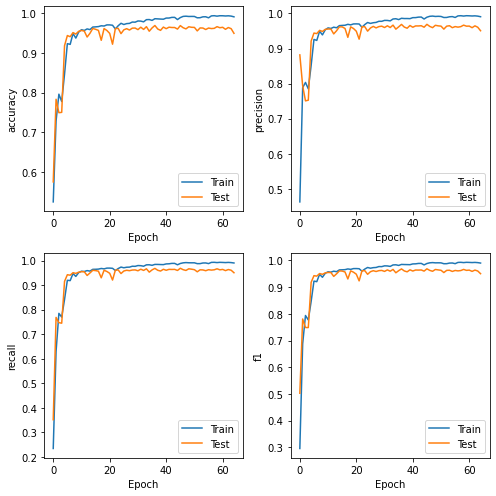

In [257]:
plot_train_history(history)
plt.savefig(f'{output_dir}/plot_train_history_12x12.png')  # Save the entire grid of images


Normalized confusion matrix
Precision: 0.9514058961459106
Accuracy: 0.9487927832316264
Recall: 0.9476485362107603
F1-score: 0.9481720009677245


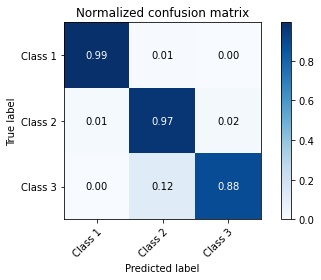

In [258]:
model_test_summary(model)
plt.savefig(f'{output_dir}/plot_confusion_matrix_12x12.png')  # Save the entire grid of images



## 16x16

In [259]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [260]:
from skimage import color
from skimage import io

In [261]:
img1=mpimg.imread('class1.jpg')
img2=mpimg.imread('class2.jpg')
img3=mpimg.imread('class3.jpg')

In [262]:
img1_gr=color.rgb2gray(img1)
img2_gr=color.rgb2gray(img2)
img3_gr=color.rgb2gray(img3)

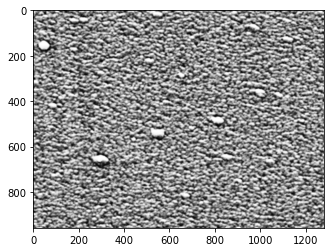

In [263]:
class_names=["Class 1","Class 2","Class 3"]
plt.imshow(img1_gr, cmap="gray")
plt.grid(False)

In [264]:
sx=16
sy=16

In [265]:
MAX_X = img1_gr.shape[0]
MAX_Y = img1_gr.shape[1]

In [266]:
class1_data=[]
class2_data=[]
class3_data=[]

for x_coord in np.arange(0,MAX_X-sx,sx):
    for y_coord in np.arange(0,MAX_Y-sy,sy):
        class1_data.append(img1_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class2_data.append(img2_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class3_data.append(img3_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])

Class 1


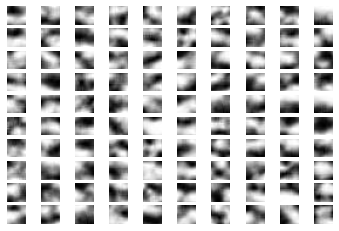

In [267]:
print("Class 1")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class1_data[np.random.randint(0,len(class1_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 2


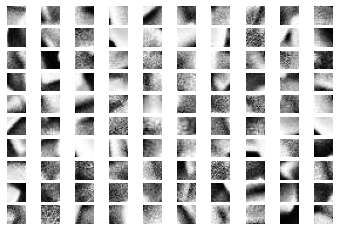

In [268]:
print("Class 2")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class2_data[np.random.randint(0,len(class2_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 3


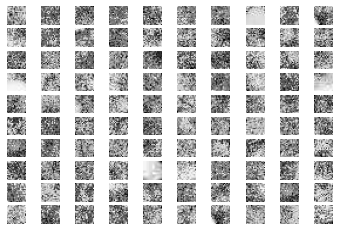

In [269]:
print("Class 3")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class3_data[np.random.randint(0,len(class3_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

In [270]:
X = np.vstack([class1_data, class2_data, class3_data])

In [271]:
labels = np.array([0]*len(class1_data) + [1]*len(class2_data) + [2]*len(class3_data))

In [272]:
color_dict={0:"red",1:"lightgreen",2:"blue"}

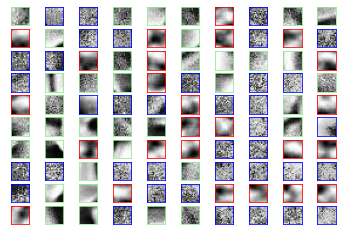

In [273]:
for i in range(100):
    plt.subplot(10,10,i+1)
    ind=np.random.randint(0,len(X))
    plt.imshow(X[ind], cmap="gray")
    ax = plt.gca()
    c=color_dict[labels[ind]]
    plt.setp(ax.spines.values(), color=c)
    #plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.grid(False)
plt.show()

In [274]:
from sklearn.preprocessing import OneHotEncoder

In [275]:
y = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))

In [276]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K

In [277]:
def prob_to_class(y):
     return np.argmax(y,axis=1).reshape(-1,1)
    
def probabilities_to_class_converter(func):
    def f(y_true,y_pred,*args,**kwargs):
        return func(prob_to_class(y_true), prob_to_class(y_pred),*args,**kwargs)
    return f
def max_probability_confusion_matrix(y_true, y_pred):
    return confusion_matrix(
        prob_to_class(y_true),
        prob_to_class(y_pred)
    )
accuracy_score=probabilities_to_class_converter(accuracy_score)
precision_score=probabilities_to_class_converter(precision_score)
recall_score=probabilities_to_class_converter(recall_score)
f1_score = probabilities_to_class_converter(f1_score)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def plot_confusion_matrix(conf_matrix,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = conf_matrix
    # Only use the labels that appear in the data
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax


def plot_train_history(history):
    metrics=["accuracy","precision","recall","f1"]

    plt.figure(figsize=(7,7))

    for i,metric in enumerate(metrics):
        plt.subplot(2,2,i+1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history['val_'+metric], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    
    
def model_predict(model):
    return model.predict(X_test_ch)


def model_test_summary(model):
    y_pred = model_predict(model)
    cm=max_probability_confusion_matrix(y_test,y_pred)
    cm_df=pd.DataFrame(cm, columns=class_names, index=class_names)
    plot_confusion_matrix(cm,normalize=True)
    print("Precision: {}\nAccuracy: {}\nRecall: {}\nF1-score: {}".format(
        precision_score(y_test, y_pred, average="macro"),
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro")
    ))
    
    
def model_wrong_predictions(model):
    y_pred = model_predict(model)
    
    y_pred_class=prob_to_class(y_pred)    
    y_t=np.array(y_test_class.reshape(-1))[0]
    y_p=np.array(y_pred_class.reshape(-1))

    pred_df=pd.DataFrame({"True":y_t, "Pred":y_p})

    pred_df["Error"]=pred_df["True"]!=pred_df["Pred"]

    err_df=pred_df[pred_df["Error"]]

    for cl in range(3):
        print("True class: ",cl+1)
        subdf=err_df[err_df["True"]==cl]


        other_cl=list(range(3))
        other_cl.remove(cl)

        for pred_cl in other_cl:
            wrong_pred=subdf[subdf["Pred"]==pred_cl].index
            if len(wrong_pred)>0:
                wrong_predicted_indices=np.random.choice(subdf[subdf["Pred"]==pred_cl].index,size=4)

                print("Wrongly predicted as Class "+str(pred_cl+1))
                for ax_i,ind in enumerate(wrong_predicted_indices):
                    plt.subplot(2,2,ax_i+1)
                    plt.imshow(X_test[ind],cmap="gray")
                    plt.axis("off")
                    plt.grid(False)
                plt.show()
                
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42, shuffle=True)

In [278]:
y_test_class=prob_to_class(y_test)

In [279]:
X_train_ch=X_train.reshape(-1,sx,sy,1)
X_test_ch=X_test.reshape(-1,sx,sy,1)

In [280]:
input_shape = (sx,sy,1)
X_test_ch.shape

(2098, 16, 16, 1)

In [281]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer,Flatten,BatchNormalization,AveragePooling2D

input_shape=(sx,sy,1)

In [282]:
model=Sequential()#94.80

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(36, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(8,8,1)))




model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(150,input_shape=input_shape, activation="relu"))

model.add(Dense(100,input_shape=input_shape, activation="relu"))#94

model.add(Dense(50, activation="relu"))#94
model.add(Dense(20, activation="tanh"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure
model.add(Dense(10, activation="relu"))#92 per

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 15, 15, 64)        320       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 14, 14, 36)        9252      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 13, 13, 8)         1160      
_________________________________________________________________
flatten_13 (Flatten)         (None, 1352)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 150)               202950    
_________________________________________________________________
dense_79 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_80 (Dense)             (None, 50)              

2023-10-15 02:14:10.066118: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


In [283]:
history=model.fit(X_train_ch,y_train, validation_data=(X_test_ch,y_test), batch_size=400, epochs=65, callbacks =[tensorboard_callback])

Epoch 1/65
 1/30 [>.............................] - ETA: 0s - loss: 1.1034 - accuracy: 0.3100 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:14:14.785925: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


 2/30 [=>............................] - ETA: 6s - loss: 1.1060 - accuracy: 0.3050 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:14:15.169187: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/train/plugins/profile/2023_10_15_02_14_15
2023-10-15 02:14:15.172295: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_10_15_02_14_15/jupyter.trace.json.gz
2023-10-15 02:14:15.173484: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.045 ms

2023-10-15 02:14:15.179415: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: logs/train/plugins/profile/2023_10_15_02_14_15Dumped tool data for overview_page.pb to logs/train/plugins/profile/2023_10_15_02_14_15/jupyter.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2023_10_15_02_14_15/jupyter.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2023_10_15_02_14_15/jupyter.tensorflow_stats.pb
Dumped tool data for

30/30 [==============================] - 12s 415ms/step - loss: 1.0404 - accuracy: 0.5104 - precision: 0.3516 - recall: 0.0759 - f1: 0.1138 - val_loss: 0.8500 - val_accuracy: 0.6663 - val_precision: 0.9704 - val_recall: 0.3666 - val_f1: 0.5315
Epoch 2/65
30/30 [==============================] - 10s 319ms/step - loss: 0.6682 - accuracy: 0.7154 - precision: 0.8130 - recall: 0.5858 - f1: 0.6746 - val_loss: 0.5407 - val_accuracy: 0.8089 - val_precision: 0.8625 - val_recall: 0.7067 - val_f1: 0.7767
Epoch 3/65
30/30 [==============================] - 9s 303ms/step - loss: 0.3939 - accuracy: 0.8671 - precision: 0.8839 - recall: 0.8351 - f1: 0.8583 - val_loss: 0.2739 - val_accuracy: 0.9266 - val_precision: 0.9365 - val_recall: 0.9244 - val_f1: 0.9304
Epoch 4/65
30/30 [==============================] - 9s 307ms/step - loss: 0.2579 - accuracy: 0.9185 - precision: 0.9225 - recall: 0.9120 - f1: 0.9172 - val_loss: 0.2011 - val_accuracy: 0.9466 - val_precision: 0.9529 - val_recall: 0.9461 - val_f1: 

30/30 [==============================] - 9s 308ms/step - loss: 0.0184 - accuracy: 0.9936 - precision: 0.9942 - recall: 0.9930 - f1: 0.9936 - val_loss: 0.0843 - val_accuracy: 0.9714 - val_precision: 0.9757 - val_recall: 0.9724 - val_f1: 0.9741


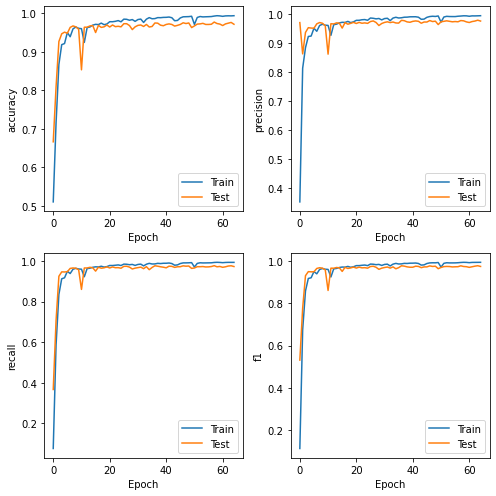

In [284]:
plot_train_history(history)
plt.savefig(f'{output_dir}/plot_train_history_16x16.png')  # Save the entire grid of images


Normalized confusion matrix
Precision: 0.9713084681557023
Accuracy: 0.9714013346043852
Recall: 0.9711155189416059
F1-score: 0.9710977757956062


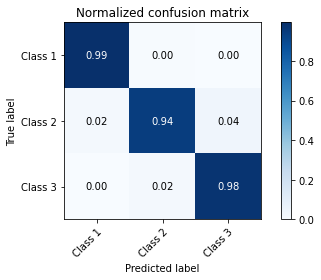

In [285]:
model_test_summary(model)
plt.savefig(f'{output_dir}/plot_confusion_matrix_16x16.png')  # Save the entire grid of images



# # 28x28

In [286]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [287]:
from skimage import color
from skimage import io

In [288]:
img1=mpimg.imread('class1.jpg')
img2=mpimg.imread('class2.jpg')
img3=mpimg.imread('class3.jpg')

In [289]:
img1_gr=color.rgb2gray(img1)
img2_gr=color.rgb2gray(img2)
img3_gr=color.rgb2gray(img3)

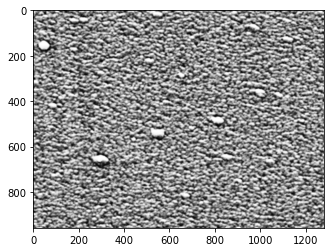

In [290]:
class_names=["Class 1","Class 2","Class 3"]
plt.imshow(img1_gr, cmap="gray")
plt.grid(False)

In [291]:
sx=28
sy=28

In [292]:
MAX_X = img1_gr.shape[0]
MAX_Y = img1_gr.shape[1]

In [293]:
class1_data=[]
class2_data=[]
class3_data=[]

for x_coord in np.arange(0,MAX_X-sx,sx):
    for y_coord in np.arange(0,MAX_Y-sy,sy):
        class1_data.append(img1_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class2_data.append(img2_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class3_data.append(img3_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])

Class 1


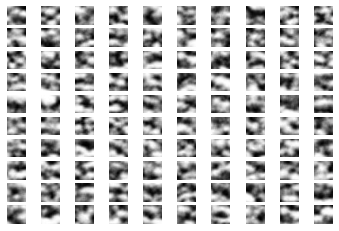

In [294]:
print("Class 1")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class1_data[np.random.randint(0,len(class1_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 2


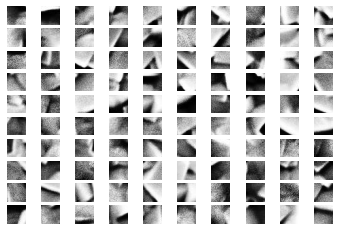

In [295]:
print("Class 2")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class2_data[np.random.randint(0,len(class2_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 3


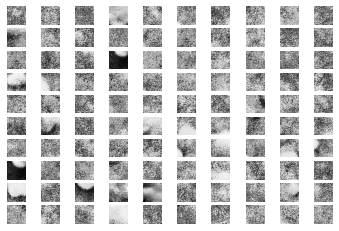

In [296]:
print("Class 3")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class3_data[np.random.randint(0,len(class3_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

In [297]:
X = np.vstack([class1_data, class2_data, class3_data])

In [298]:
labels = np.array([0]*len(class1_data) + [1]*len(class2_data) + [2]*len(class3_data))

In [299]:
color_dict={0:"red",1:"lightgreen",2:"blue"}

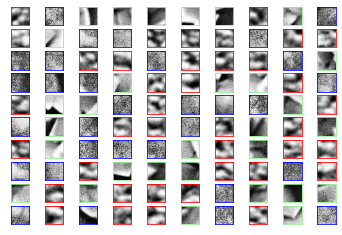

In [300]:
for i in range(100):
    plt.subplot(10,10,i+1)
    ind=np.random.randint(0,len(X))
    plt.imshow(X[ind], cmap="gray")
    ax = plt.gca()
    c=color_dict[labels[ind]]
    plt.setp(ax.spines.values(), color=c)
    #plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.grid(False)
plt.show()

In [301]:
from sklearn.preprocessing import OneHotEncoder

In [302]:
y = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))

In [303]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K

In [304]:
def prob_to_class(y):
     return np.argmax(y,axis=1).reshape(-1,1)
    
def probabilities_to_class_converter(func):
    def f(y_true,y_pred,*args,**kwargs):
        return func(prob_to_class(y_true), prob_to_class(y_pred),*args,**kwargs)
    return f
def max_probability_confusion_matrix(y_true, y_pred):
    return confusion_matrix(
        prob_to_class(y_true),
        prob_to_class(y_pred)
    )
accuracy_score=probabilities_to_class_converter(accuracy_score)
precision_score=probabilities_to_class_converter(precision_score)
recall_score=probabilities_to_class_converter(recall_score)
f1_score = probabilities_to_class_converter(f1_score)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def plot_confusion_matrix(conf_matrix,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = conf_matrix
    # Only use the labels that appear in the data
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax


def plot_train_history(history):
    metrics=["accuracy","precision","recall","f1"]

    plt.figure(figsize=(7,7))

    for i,metric in enumerate(metrics):
        plt.subplot(2,2,i+1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history['val_'+metric], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    
    
def model_predict(model):
    return model.predict(X_test_ch)


def model_test_summary(model):
    y_pred = model_predict(model)
    cm=max_probability_confusion_matrix(y_test,y_pred)
    cm_df=pd.DataFrame(cm, columns=class_names, index=class_names)
    plot_confusion_matrix(cm,normalize=True)
    print("Precision: {}\nAccuracy: {}\nRecall: {}\nF1-score: {}".format(
        precision_score(y_test, y_pred, average="macro"),
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro")
    ))
    
    
def model_wrong_predictions(model):
    y_pred = model_predict(model)
    
    y_pred_class=prob_to_class(y_pred)    
    y_t=np.array(y_test_class.reshape(-1))[0]
    y_p=np.array(y_pred_class.reshape(-1))

    pred_df=pd.DataFrame({"True":y_t, "Pred":y_p})

    pred_df["Error"]=pred_df["True"]!=pred_df["Pred"]

    err_df=pred_df[pred_df["Error"]]

    for cl in range(3):
        print("True class: ",cl+1)
        subdf=err_df[err_df["True"]==cl]


        other_cl=list(range(3))
        other_cl.remove(cl)

        for pred_cl in other_cl:
            wrong_pred=subdf[subdf["Pred"]==pred_cl].index
            if len(wrong_pred)>0:
                wrong_predicted_indices=np.random.choice(subdf[subdf["Pred"]==pred_cl].index,size=4)

                print("Wrongly predicted as Class "+str(pred_cl+1))
                for ax_i,ind in enumerate(wrong_predicted_indices):
                    plt.subplot(2,2,ax_i+1)
                    plt.imshow(X_test[ind],cmap="gray")
                    plt.axis("off")
                    plt.grid(False)
                plt.show()
                
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42, shuffle=True)

In [305]:
y_test_class=prob_to_class(y_test)

In [306]:
X_train_ch=X_train.reshape(-1,sx,sy,1)
X_test_ch=X_test.reshape(-1,sx,sy,1)

In [307]:
input_shape = (sx,sy,1)
X_test_ch.shape

(689, 28, 28, 1)

In [308]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer,Flatten,BatchNormalization,AveragePooling2D,Conv2D
import tensorflow as tf

input_shape=(sx,sy,1)

In [309]:
model=Sequential()#94.80

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (4,4), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(36, (2,2), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(8,8,1)))




model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(150,input_shape=input_shape, activation="relu"))

model.add(Dense(100,input_shape=input_shape, activation="relu"))#94

model.add(Dense(50, activation="relu"))#94
model.add(Dense(20, activation="tanh"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure
model.add(Dense(10, activation="relu"))#92 per

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 25, 25, 64)        1088      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 36)        9252      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 23, 23, 8)         1160      
_________________________________________________________________
flatten_14 (Flatten)         (None, 4232)              0         
_________________________________________________________________
dense_84 (Dense)             (None, 150)               634950    
_________________________________________________________________
dense_85 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_86 (Dense)             (None, 50)              

2023-10-15 02:24:41.421255: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


In [310]:
history=model.fit(X_train_ch,y_train, validation_data=(X_test_ch,y_test), batch_size=400, epochs=100, callbacks =[tensorboard_callback])

Epoch 1/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.0986 - accuracy: 0.3425 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:24:47.276944: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


 2/10 [=====>........................] - ETA: 4s - loss: 1.0962 - accuracy: 0.3600 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:24:48.337687: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/train/plugins/profile/2023_10_15_02_24_48
2023-10-15 02:24:48.341173: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_10_15_02_24_48/jupyter.trace.json.gz
2023-10-15 02:24:48.342231: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.039 ms

2023-10-15 02:24:48.349670: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: logs/train/plugins/profile/2023_10_15_02_24_48Dumped tool data for overview_page.pb to logs/train/plugins/profile/2023_10_15_02_24_48/jupyter.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2023_10_15_02_24_48/jupyter.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2023_10_15_02_24_48/jupyter.tensorflow_stats.pb
Dumped tool data for

10/10 [==============================] - 9s 891ms/step - loss: 1.0956 - accuracy: 0.3802 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.0844 - val_accuracy: 0.3280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 7s 735ms/step - loss: 1.0467 - accuracy: 0.4373 - precision: 0.3433 - recall: 0.0598 - f1: 0.0979 - val_loss: 0.9659 - val_accuracy: 0.5123 - val_precision: 0.9448 - val_recall: 0.2980 - val_f1: 0.4531
Epoch 3/100
10/10 [==============================] - 7s 739ms/step - loss: 0.8459 - accuracy: 0.6068 - precision: 0.8031 - recall: 0.4600 - f1: 0.5711 - val_loss: 0.6881 - val_accuracy: 0.6836 - val_precision: 0.7889 - val_recall: 0.6534 - val_f1: 0.7148
Epoch 4/100
10/10 [==============================] - 7s 741ms/step - loss: 0.6071 - accuracy: 0.7249 - precision: 0.8071 - recall: 0.6416 - f1: 0.7146 - val_loss: 0.4757 - val_accuracy: 0.8258 - val_precision: 0.8844 - val_

Epoch 33/100
10/10 [==============================] - 7s 713ms/step - loss: 0.0347 - accuracy: 0.9903 - precision: 0.9907 - recall: 0.9901 - f1: 0.9904 - val_loss: 0.0443 - val_accuracy: 0.9898 - val_precision: 0.9915 - val_recall: 0.9903 - val_f1: 0.9909
Epoch 34/100
10/10 [==============================] - 8s 765ms/step - loss: 0.0318 - accuracy: 0.9928 - precision: 0.9932 - recall: 0.9927 - f1: 0.9929 - val_loss: 0.0405 - val_accuracy: 0.9898 - val_precision: 0.9893 - val_recall: 0.9893 - val_f1: 0.9893
Epoch 35/100
10/10 [==============================] - 8s 759ms/step - loss: 0.0316 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9903 - f1: 0.9905 - val_loss: 0.0416 - val_accuracy: 0.9927 - val_precision: 0.9923 - val_recall: 0.9923 - val_f1: 0.9923
Epoch 36/100
10/10 [==============================] - 7s 744ms/step - loss: 0.0315 - accuracy: 0.9913 - precision: 0.9914 - recall: 0.9903 - f1: 0.9909 - val_loss: 0.0528 - val_accuracy: 0.9840 - val_precision: 0.9829 - val_recall: 

10/10 [==============================] - 8s 771ms/step - loss: 0.0155 - accuracy: 0.9959 - precision: 0.9958 - recall: 0.9958 - f1: 0.9958 - val_loss: 0.0394 - val_accuracy: 0.9927 - val_precision: 0.9928 - val_recall: 0.9928 - val_f1: 0.9928
Epoch 66/100
10/10 [==============================] - 8s 766ms/step - loss: 0.0158 - accuracy: 0.9949 - precision: 0.9952 - recall: 0.9950 - f1: 0.9951 - val_loss: 0.0405 - val_accuracy: 0.9913 - val_precision: 0.9911 - val_recall: 0.9911 - val_f1: 0.9911
Epoch 67/100
10/10 [==============================] - 7s 741ms/step - loss: 0.0171 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9935 - f1: 0.9936 - val_loss: 0.0432 - val_accuracy: 0.9913 - val_precision: 0.9911 - val_recall: 0.9911 - val_f1: 0.9911
Epoch 68/100
10/10 [==============================] - 8s 762ms/step - loss: 0.0149 - accuracy: 0.9954 - precision: 0.9961 - recall: 0.9953 - f1: 0.9957 - val_loss: 0.0414 - val_accuracy: 0.9927 - val_precision: 0.9928 - val_recall: 0.9928 - val_

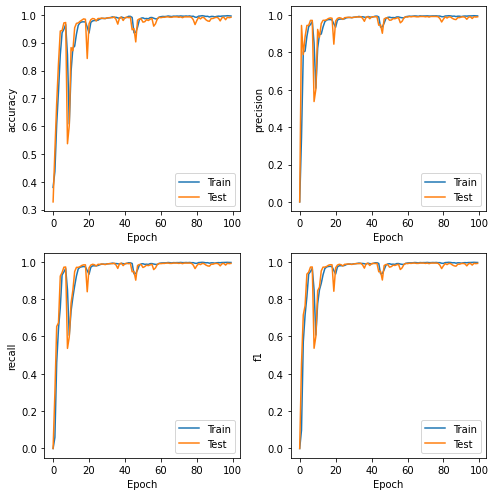

In [311]:
plot_train_history(history)
plt.savefig(f'{output_dir}/plot_train_history_28x28.png')  # Save the entire grid of images


Normalized confusion matrix
Precision: 0.9912525022296217
Accuracy: 0.9912917271407837
Recall: 0.990999058849582
F1-score: 0.991115692759946


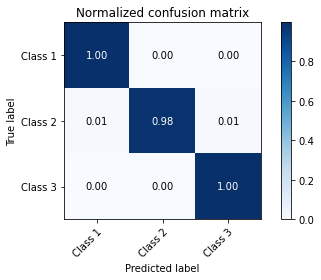

In [312]:
model_test_summary(model)

plt.savefig(f'{output_dir}/plot_confusion_matrix_28x28.png')  # Save the entire grid of images


# # 32x32

In [313]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [314]:
from skimage import color
from skimage import io

In [315]:
img1=mpimg.imread('class1.jpg')
img2=mpimg.imread('class2.jpg')
img3=mpimg.imread('class3.jpg')

In [316]:
img1_gr=color.rgb2gray(img1)
img2_gr=color.rgb2gray(img2)
img3_gr=color.rgb2gray(img3)

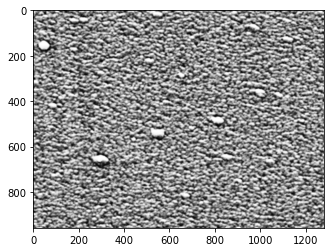

In [317]:
class_names=["Class 1","Class 2","Class 3"]
plt.imshow(img1_gr, cmap="gray")
plt.grid(False)

In [318]:
sx=32
sy=32

In [319]:
MAX_X = img1_gr.shape[0]
MAX_Y = img1_gr.shape[1]

In [320]:
class1_data=[]
class2_data=[]
class3_data=[]

for x_coord in np.arange(0,MAX_X-sx,sx):
    for y_coord in np.arange(0,MAX_Y-sy,sy):
        class1_data.append(img1_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class2_data.append(img2_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])
        class3_data.append(img3_gr[x_coord:x_coord+sx, y_coord:y_coord+sy])

Class 1


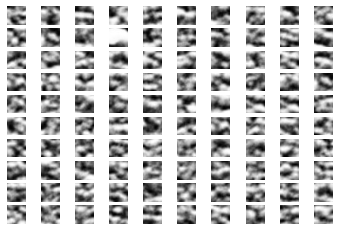

In [321]:
print("Class 1")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class1_data[np.random.randint(0,len(class1_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 2


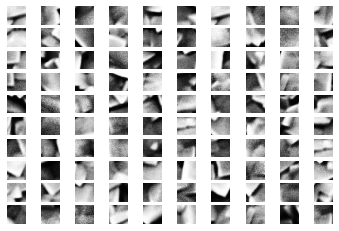

In [322]:
print("Class 2")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class2_data[np.random.randint(0,len(class2_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

Class 3


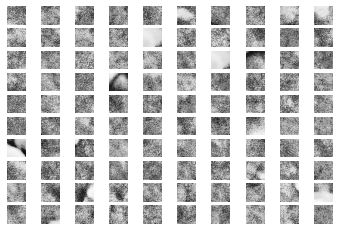

In [323]:
print("Class 3")
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(class3_data[np.random.randint(0,len(class3_data))], cmap="gray")
    plt.axis('off')
    plt.grid(False)
plt.show()

In [324]:
X = np.vstack([class1_data, class2_data, class3_data])

In [325]:
labels = np.array([0]*len(class1_data) + [1]*len(class2_data) + [2]*len(class3_data))

In [326]:
color_dict={0:"red",1:"lightgreen",2:"blue"}

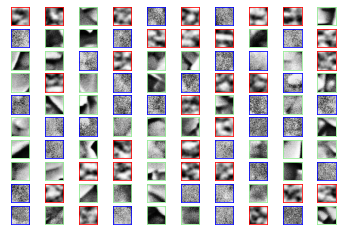

In [327]:
for i in range(100):
    plt.subplot(10,10,i+1)
    ind=np.random.randint(0,len(X))
    plt.imshow(X[ind], cmap="gray")
    ax = plt.gca()
    c=color_dict[labels[ind]]
    plt.setp(ax.spines.values(), color=c)
    #plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.grid(False)
plt.show()

In [328]:
from sklearn.preprocessing import OneHotEncoder

In [329]:
y = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))

In [330]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K

In [331]:
def prob_to_class(y):
     return np.argmax(y,axis=1).reshape(-1,1)
    
def probabilities_to_class_converter(func):
    def f(y_true,y_pred,*args,**kwargs):
        return func(prob_to_class(y_true), prob_to_class(y_pred),*args,**kwargs)
    return f
def max_probability_confusion_matrix(y_true, y_pred):
    return confusion_matrix(
        prob_to_class(y_true),
        prob_to_class(y_pred)
    )
accuracy_score=probabilities_to_class_converter(accuracy_score)
precision_score=probabilities_to_class_converter(precision_score)
recall_score=probabilities_to_class_converter(recall_score)
f1_score = probabilities_to_class_converter(f1_score)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def plot_confusion_matrix(conf_matrix,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = conf_matrix
    # Only use the labels that appear in the data
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax


def plot_train_history(history):
    metrics=["accuracy","precision","recall","f1"]

    plt.figure(figsize=(7,7))

    for i,metric in enumerate(metrics):
        plt.subplot(2,2,i+1)
        plt.plot(history.history[metric], label="Train")
        plt.plot(history.history['val_'+metric], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    
    
def model_predict(model):
    return model.predict(X_test_ch)


def model_test_summary(model):
    y_pred = model_predict(model)
    cm=max_probability_confusion_matrix(y_test,y_pred)
    cm_df=pd.DataFrame(cm, columns=class_names, index=class_names)
    plot_confusion_matrix(cm,normalize=True)
    print("Precision: {}\nAccuracy: {}\nRecall: {}\nF1-score: {}".format(
        precision_score(y_test, y_pred, average="macro"),
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro")
    ))
    
    
def model_wrong_predictions(model):
    y_pred = model_predict(model)
    
    y_pred_class=prob_to_class(y_pred)    
    y_t=np.array(y_test_class.reshape(-1))[0]
    y_p=np.array(y_pred_class.reshape(-1))

    pred_df=pd.DataFrame({"True":y_t, "Pred":y_p})

    pred_df["Error"]=pred_df["True"]!=pred_df["Pred"]

    err_df=pred_df[pred_df["Error"]]

    for cl in range(3):
        print("True class: ",cl+1)
        subdf=err_df[err_df["True"]==cl]


        other_cl=list(range(3))
        other_cl.remove(cl)

        for pred_cl in other_cl:
            wrong_pred=subdf[subdf["Pred"]==pred_cl].index
            if len(wrong_pred)>0:
                wrong_predicted_indices=np.random.choice(subdf[subdf["Pred"]==pred_cl].index,size=4)

                print("Wrongly predicted as Class "+str(pred_cl+1))
                for ax_i,ind in enumerate(wrong_predicted_indices):
                    plt.subplot(2,2,ax_i+1)
                    plt.imshow(X_test[ind],cmap="gray")
                    plt.axis("off")
                    plt.grid(False)
                plt.show()
                
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42, shuffle=True)

In [332]:
y_test_class=prob_to_class(y_test)

In [333]:
X_train_ch=X_train.reshape(-1,sx,sy,1)
X_test_ch=X_test.reshape(-1,sx,sy,1)

In [334]:
input_shape = (sx,sy,1)
X_test_ch.shape

(509, 32, 32, 1)

In [335]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer,Flatten,BatchNormalization,AveragePooling2D

input_shape=(sx,sy,1)

In [336]:
model=Sequential()#94.80

#model.add(InputLayer(input_shape=input_shape))
#model.add(Conv2D(10, (2, 2), input_shape=(8, 8, 1), activation='relu'))
#model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(InputLayer(input_shape=input_shape))

model.add(Conv2D(64, (4,4), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(36, (4,4), 1, activation='relu', input_shape=(8,8,1)))


model.add(Conv2D(8, (4,4), 1, activation='relu', input_shape=(8,8,1)))




model.add(Flatten())
#model.add(Dense(100,input_shape=input_shape, activation="relu"))
#model.add(Dense(50, activation="tanh"))

model.add(Dense(150,input_shape=input_shape, activation="relu"))

model.add(Dense(100,input_shape=input_shape, activation="relu"))#94

model.add(Dense(50, activation="relu"))#94
model.add(Dense(20, activation="tanh"))#92 per
#model.add(Dense(6, activation="relu")) # 93 prsentage acure
model.add(Dense(10, activation="relu"))#92 per

model.add(Dense(3,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision,recall,f1])
logdir='logs'
tensorboard_callback = tf.keras.callbacks. TensorBoard(log_dir=logdir)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 29, 29, 64)        1088      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 26, 26, 36)        36900     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 23, 23, 8)         4616      
_________________________________________________________________
flatten_15 (Flatten)         (None, 4232)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 150)               634950    
_________________________________________________________________
dense_91 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_92 (Dense)             (None, 50)              

2023-10-15 02:38:53.818327: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


In [337]:
history=model.fit(X_train_ch,y_train, validation_data=(X_test_ch,y_test), batch_size=300, epochs=30, callbacks =[tensorboard_callback])

Epoch 1/30
 1/10 [==>...........................] - ETA: 0s - loss: 1.0987 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:38:57.340818: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


 2/10 [=====>........................] - ETA: 8s - loss: 1.0992 - accuracy: 0.3417 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00

2023-10-15 02:38:59.509093: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: logs/train/plugins/profile/2023_10_15_02_38_59
2023-10-15 02:38:59.511891: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_10_15_02_38_59/jupyter.trace.json.gz
2023-10-15 02:38:59.512846: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.041 ms

2023-10-15 02:38:59.518830: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: logs/train/plugins/profile/2023_10_15_02_38_59Dumped tool data for overview_page.pb to logs/train/plugins/profile/2023_10_15_02_38_59/jupyter.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2023_10_15_02_38_59/jupyter.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2023_10_15_02_38_59/jupyter.tensorflow_stats.pb
Dumped tool data for

10/10 [==============================] - 17s 2s/step - loss: 1.0993 - accuracy: 0.3613 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.0955 - val_accuracy: 0.3576 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/30
10/10 [==============================] - 16s 2s/step - loss: 1.0860 - accuracy: 0.3970 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 1.0645 - val_accuracy: 0.4676 - val_precision: 1.0000 - val_recall: 0.0194 - val_f1: 0.0378
Epoch 3/30
10/10 [==============================] - 16s 2s/step - loss: 0.9833 - accuracy: 0.5222 - precision: 0.8738 - recall: 0.1712 - f1: 0.2423 - val_loss: 0.9261 - val_accuracy: 0.5540 - val_precision: 0.7829 - val_recall: 0.4845 - val_f1: 0.5984
Epoch 4/30
10/10 [==============================] - 16s 2s/step - loss: 0.8285 - accuracy: 0.6085 - precision: 0.7619 - recall: 0.5003 - f1: 0.6019 - val_loss: 0.8275 - val_accuracy: 0.5933 - val_precision: 0.6441 - val

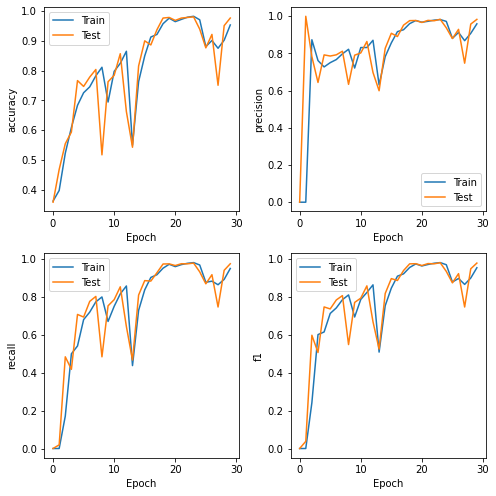

In [338]:
plot_train_history(history)
plt.savefig(f'{output_dir}/plot_train_history_32x32.png')  # Save the entire grid of images


Normalized confusion matrix
Precision: 0.9769734446676642
Accuracy: 0.9764243614931237
Recall: 0.9747659047285717
F1-score: 0.9757596853462909


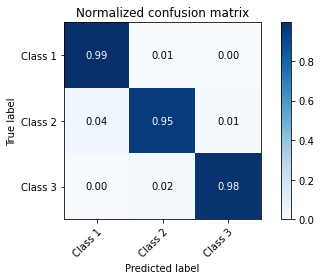

In [339]:
model_test_summary(model)

plt.savefig(f'{output_dir}/plot_confusion_matrix_32x32.png')  # Save the entire grid of images
